In [1]:
import numpy as np
import pyslsa
import matplotlib.pyplot as plt
%matplotlib inline
import neuraltda.topology2 as tp2
import neuraltda.simpComp as sc
import neuraltda.spectralAnalysis as sa
import pandas as pd
import h5py as h5

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TPEnv:
    
    def __init__(self, n_holes, hole_rad):
        self.xlim = [-1, 1]
        self.ylim = [-1, 1]
        self.holes = []
        self.hole_rad = hole_rad
        c = 0.75*(2*np.random.rand(2) - 1)
        for hole in range(n_holes):
            while self.hole_collide(c):
                c = 0.75*(2*np.random.rand(2) - 1)
            self.holes.append(c)
        #self.holes = 0.75*(2*np.random.rand(n_holes, 2) - 1) # keep centers in range -1, 1
        self.hole_rad = hole_rad # radius of holes
        
    def in_hole(self, x, y):
        for hole in self.holes:
            if np.linalg.norm(np.subtract([x, y], hole)) < self.hole_rad:
                return True
        return False
        
    def hole_collide(self, c):
        for h in self.holes:
            if np.sqrt((h[0] - c[0])**2 + (h[1] - c[1])**2) <= 2*self.hole_rad:
                return True
        return False
 

In [33]:
def generate_environments(N, h, numrepeats=1):
    envs = []
    for nholes in range(N):
        for r in range(numrepeats):
            envs.append(TPEnv(nholes, h))
    return envs

def convert_env_to_img(env,  NSQ):
    img = np.ones((NSQ, NSQ))
    X, Y = np.meshgrid(np.linspace(-1, 1, NSQ), np.linspace(-1, 1, NSQ))
    
    for hole in env.holes:
        hx = hole[0]
        hy = hole[1]
        diffx = X - hx*np.ones(np.shape(X))
        diffy = Y - hy*np.ones(np.shape(Y))
        dists = np.sqrt(np.power(diffx, 2) + np.power(diffy, 2))
        img[dists < env.hole_rad] = 0
        
    return img 

def compute_env_img_correlations(imgs):
    nsq, _ = np.shape(imgs[0])
    dat_mat = np.zeros((len(imgs), nsq*nsq))
    for ind,img in enumerate(imgs):
        dat_mat[ind, :] = img.flatten()
        
    cormat = np.corrcoef(dat_mat)
    return cormat
    

def generate_paths(space, n_steps, ntrials, dl):
    # pick a starting point
    final_pts = np.zeros((ntrials, n_steps, 2))
    for trial in range(ntrials):
        pts = []
        pt = (2*np.random.rand(1, 2) - 1)[0]
        while space.in_hole(pt[0], pt[1]):
            pt = (2*np.random.rand(1, 2) - 1)[0]
        #pts.append(pt)
        steps_to_go = n_steps
        while steps_to_go > 0:
            if steps_to_go % 10000 == 0:
                print("Steps to go: {}".format(steps_to_go))
            # pick a new point
            #theta = np.pi*np.random.rand(1)[0] - np.pi/2
            
            theta = 2*np.pi*np.random.rand(1)[0]
            dx = dl*np.cos(theta)
            dy = dl*np.sin(theta)

            if (abs(pt[0]+dx) < 1 and 
               abs(pt[1]+dy) < 1 and
                not space.in_hole(pt[0]+dx, pt[1]+dy)):
                
                steps_to_go -= 1

                pt[0] = pt[0] + dx
                pt[1] = pt[1] + dy
                pts.append(np.copy(pt))
        pts = np.vstack(pts)
        final_pts[trial, :, :] = pts
    return final_pts

def generate_place_fields_random(n_fields, rad):
    
    centers =2*np.random.rand(n_fields, 2) - 1
    return (centers, rad)

def generate_place_fields(n_fields, rad):
    
    nf = np.round(np.sqrt(n_fields))
    cx = np.linspace(-1, 1, nf)
    cy = np.linspace(-1, 1, nf)
    centers = np.array([np.array((x, y)) for x in cx for y in cy])
    rads = rad*np.ones(n_fields)
    return (centers, rads)

def generate_place_fields_perturbed_lattice(n_fields, rad, stddev=0.1):
    ''' generates place fields with centers normally perturbed around a lattice'''
    nf = np.round(np.sqrt(n_fields))
    cx = np.linspace(-1, 1, nf)
    cy = np.linspace(-1, 1, nf)
    cx = cx + stddev*np.random.randn(len(cx))
    cy = cy + stddev*np.random.randn(len(cy))
    centers = np.array([np.array((x, y)) for x in cx for y in cy])
    return (centers, rad)

def generate_place_fields_CI(n_fields, rad_range,exclusion_param):
    radii = (rad_range[1] - rad_range[0])*np.random.random_sample(n_fields) + rad_range[0]
    field_c = []
    for field in range(n_fields):
        print('field = ', field)
        # pick a center in range -1, 1
        c = 2*np.random.rand(2) - 1
        if field == 0:
            field_c.append(c)
            continue
        added = False
        collision = False
        trie = 0
        maxtries = 100
        #print('field c', field_c)
        while trie < maxtries and added == False:
            #print('trie', trie)
            for cbar_ind, cbar in enumerate(field_c):
                #print('cbar', cbar)
                if np.linalg.norm(c-cbar) < exclusion_param*radii[cbar_ind]:
                    # already a field there, try again
                    #print('collision')
                    c = 2*np.random.rand(2) - 1
                    collision = True
                    break
            if collision:
                trie+=1
                collision = False
                continue
            else:
                field_c.append(c)
                added = True
        if not added:
            field_c.append(c)
    return (np.array(field_c), radii)
            
def generate_spikes_gaussian(paths, fields, max_rate, sigma):
    
    ncell, dim = fields.shape
    ntrial, nwin, _ = paths.shape
    
    spikes = np.zeros((ncell, nwin, ntrial))

    P1 = paths[:, :, np.newaxis, :]
    C1 = fields[np.newaxis, np.newaxis, :, :]

    P1 = np.tile(P1, [1, 1, ncell, 1])
    C1 = np.tile(C1, [ntrial, nwin, 1, 1])

    S = P1 - C1
    M = np.einsum('ijkl, ijkl->ijk', S, S)
    probs = max_rate*np.exp(-1*M / (2*sigma**2))
    spikes = 1*np.greater(probs, np.random.random(np.shape(probs)))
    return np.einsum('ijk->kji', spikes)

def generate_spikes(paths, fields, max_rate, rads):
    
    ncell, dim = fields.shape
    ntrial, nwin, _ = paths.shape
    
    spikes = np.zeros((ncell, nwin, ntrial))

    P1 = paths[:, :, np.newaxis, :]
    C1 = fields[np.newaxis, np.newaxis, :, :]

    P1 = np.tile(P1, [1, 1, ncell, 1])
    C1 = np.tile(C1, [ntrial, nwin, 1, 1])

    S = P1 - C1
    M = np.einsum('ijkl, ijkl->ijk', S, S)
    #SIGMA = sigma*np.ones(M.shape)
    SIGMA = np.tile(rads[np.newaxis, np.newaxis, :], (ntrial, nwin, 1))
    # if distance is less than sigma, then p = max_rate
    probs = max_rate*np.less(M, SIGMA)
    spikes = 1*np.greater(probs, np.random.random(np.shape(probs)))
    return np.einsum('ijk->kji', spikes)

def spikes_to_dataframe(spikes, fs, nsecs):
    (ncells, nwin, ntrial) = spikes.shape
    spikes_frame = pd.DataFrame(columns=['cluster', 'time_samples', 'recording'])
    trials_frame = pd.DataFrame(columns=['stimulus', 'time_samples', 'stimulus_end'])
    for trial in range(ntrial):
        for cell in range(ncells):
            cellspikes = np.nonzero(spikes[cell, :, trial])[0] + trial*(nsecs+2)*fs
            celldict = {'cluster': len(cellspikes)*[cell], 'time_samples': cellspikes, 'recording': len(cellspikes)*[0]}
            cellframe = pd.DataFrame(celldict)
            spikes_frame = spikes_frame.append(cellframe, ignore_index=True)
        trial_frame = pd.DataFrame({'stimulus': 'joe', 'time_samples': trial*(nsecs+2)*fs, 'stimulus_end': (trial*(nsecs+2) + nsecs)*fs, 'recording': 0}, index=[0])
        trials_frame = trials_frame.append(trial_frame, ignore_index=True)
    clusters_frame = pd.DataFrame({'cluster': range(ncells), 'quality': ncells*['Good']})
    return (spikes_frame.sort_values(by='time_samples'), trials_frame, clusters_frame)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


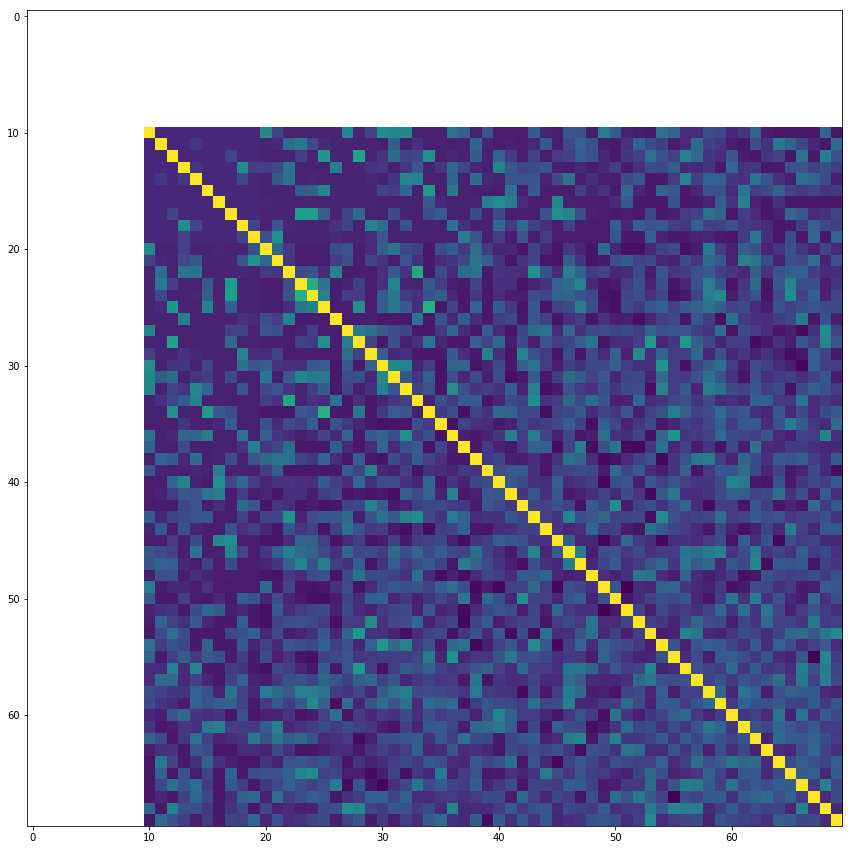

In [4]:
envs = generate_environments(7, 0.2, 10)
imgs = []
for env in envs:
    imgs.append(convert_env_to_img(env, 100))
    
corrmat = compute_env_img_correlations(imgs)
plt.figure(figsize=(15, 15))
plt.imshow(corrmat)

In [34]:
L = 2 # meter
vel = 0.1*L # meters / second

hole_rad = 0.2
nsecs = 10*60
fs = 10
nwin = nsecs*fs
ncells = 70

dl = vel/fs
dl = vel/1
ntrials = 10
exclusion_param = 1.1

max_rate_hz = 2 # spikes/ second
max_rate_phys = fs # spikes / second
max_rate = max_rate_hz / max_rate_phys
sigma = 0.1*L


env1 = TPEnv(1, hole_rad) # 1 hole
env2 = TPEnv(7, hole_rad) # 2 holes

pths1 = generate_paths(env1, nwin, ntrials, dl)  # 10 walks through environment 1
pths2 = generate_paths(env2, nwin, ntrials, dl)  # 10 walks through environment 2

(fields, rads) = generate_place_fields_CI(ncells, [0.1*L, 0.1*L], exclusion_param )
print(fields.shape)

spikes1 = generate_spikes(pths1, fields, max_rate, rads)
spikes2 = generate_spikes(pths2, fields, max_rate, rads)

field =  0
field =  1
field =  2
field =  3
field =  4
field =  5
field =  6
field =  7
field =  8
field =  9
field =  10
field =  11
field =  12
field =  13
field =  14
field =  15
field =  16
field =  17
field =  18
field =  19
field =  20
field =  21
field =  22
field =  23
field =  24
field =  25
field =  26
field =  27
field =  28
field =  29
field =  30
field =  31
field =  32
field =  33
field =  34
field =  35
field =  36
field =  37
field =  38
field =  39
field =  40
field =  41
field =  42
field =  43
field =  44
field =  45
field =  46
field =  47
field =  48
field =  49
field =  50
field =  51
field =  52
field =  53
field =  54
field =  55
field =  56
field =  57
field =  58
field =  59
field =  60
field =  61
field =  62
field =  63
field =  64
field =  65
field =  66
field =  67
field =  68
field =  69
(70, 2)


8 8


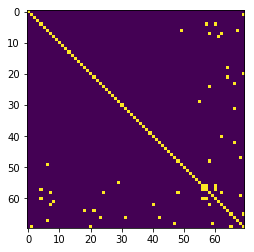

In [35]:
max_simul1 = np.amax(np.sum(spikes1, axis=0))
max_simul2 = np.amax(np.sum(spikes2, axis=0))
print(max_simul1, max_simul2)
np.sum(spikes1)

np.sum(spikes1, axis=1)[:, 0] / 600
f_distances = np.zeros((len(fields), len(fields)))
for i in range(len(fields)):
    for j in range(len(fields)):
        fi = fields[i]
        fj = fields[j]
        f_distances[i, j] = np.linalg.norm(fi-fj)
    
plt.imshow(f_distances < exclusion_param*0.1*L)

Text(0.5,1,'Environment 2')

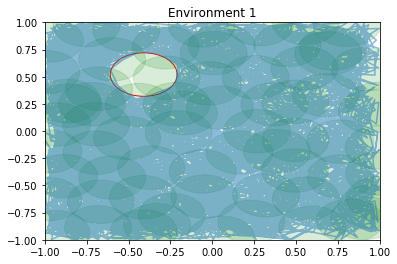

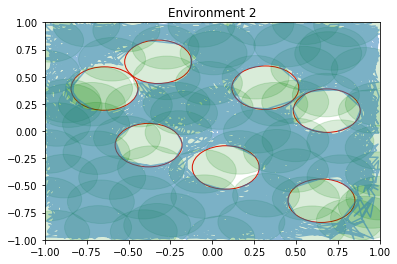

In [36]:
plt.figure()
plt.plot(pths1[0, :, 0], pths1[0, :, 1], alpha=0.5)
ax = plt.gca()
for hole in env1.holes:
    
    h1 = plt.Circle(hole, env1.hole_rad, fill=False, color='r')
    ax.add_artist(h1)
for field, rad in zip(fields, rads):
    h2 = plt.Circle(field, rad, fill=True, color='g', alpha=0.15)
    ax.add_artist(h2)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('Environment 1')

plt.figure()
plt.plot(pths2[0, :, 0], pths2[0, :, 1], alpha=0.5)
ax = plt.gca()
for hole in env2.holes:
    
    h1 = plt.Circle(hole, env2.hole_rad, fill=False, color='r')
    ax.add_artist(h1)
for field, rad in zip(fields, rads):
    h2 = plt.Circle(field, rad, fill=True, color='g', alpha=0.15)
    ax.add_artist(h2)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('Environment 2')

In [8]:
from importlib import reload
reload(tp2)
tspikes, ttrials, tclust = spikes_to_dataframe(spikes1, fs=fs, nsecs=nsecs)
tp2.build_binned_file_quick(tspikes, ttrials, tclust, 100.0, fs, ['Good'], [0, 0], '/home/brad/placecellsimdat1_CI.binned', dt_overlap=5.0)
tspikes, ttrials, tclust = spikes_to_dataframe(spikes2, fs=fs, nsecs=nsecs)
tp2.build_binned_file_quick(tspikes, ttrials, tclust, 100.0, fs, ['Good'], [0, 0], '/home/brad/placecellsimdat2_CI.binned', dt_overlap=5.0)

In [ ]:
tspikes

KeyboardInterrupt: 

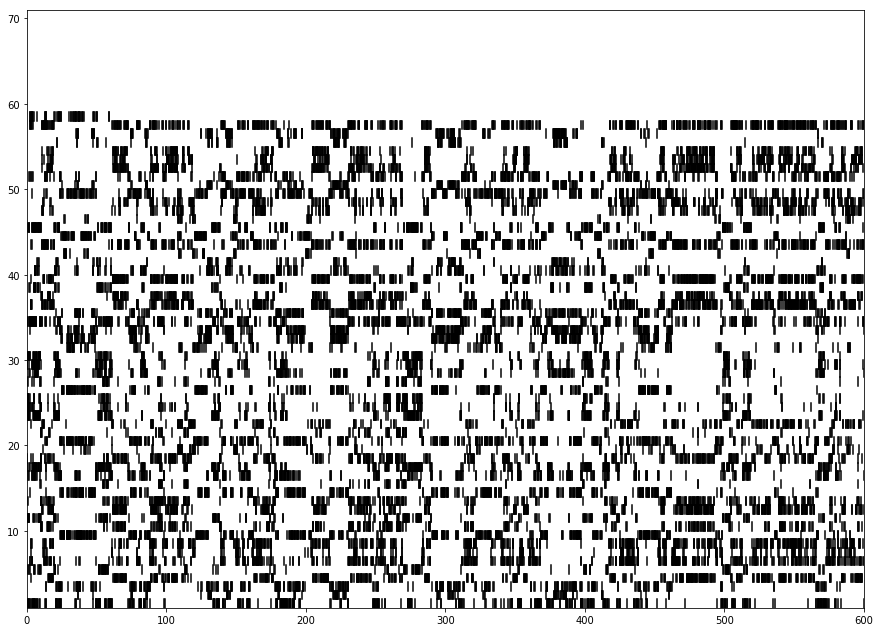

In [9]:
from ephys import rasters
plt.figure(figsize=(15,11))
rasters.plot_raster_stim_trial(tspikes, ttrials, tclust, 'joe', 0, [0,0], 0, fs)

In [10]:
E1s = []
E2s = []
with h5.File('/home/brad/placecellsimdat1_orig.binned', 'r') as bf:
    poptens = np.array(bf['joe']['pop_tens'])
    ncell, nwin, ntrial = poptens.shape
    for trial in range(ntrial):
        binmat = sc.binnedtobinary(poptens[:, :, trial], 6.0)
        print(np.amax(np.sum(binmat, axis = 0)))
        maxsimps = sc.binarytomaxsimplex(binmat, rDup=True)
        E1 = pyslsa.build_SCG(maxsimps)
        E1s.append(E1)
    
with h5.File('/home/brad/placecellsimdat2_orig.binned', 'r') as bf:
    poptens = np.array(bf['joe']['pop_tens'])
    ncell, nwin, ntrial = poptens.shape
    for trial in range(ntrial):
        binmat = sc.binnedtobinary(poptens[:, :, trial], 6.0)
        print(np.amax(np.sum(binmat, axis = 0)))
        maxsimps = sc.binarytomaxsimplex(binmat, rDup=True)
        E2 = pyslsa.build_SCG(maxsimps)
        E2s.append(E2)

beta = -1.0
dim = 1
pyslsa.JS(E1, E2, dim, beta)

7
7
7
7
7
7
7
7
7
7
7
7
8
8
7
8
7
8
7
7


0.060989055932468575

In [11]:
#compute differences
import tqdm
beta = -1.0
dim = 1
SCGs = [E1s, E2s]

In [12]:
dists = np.zeros((2*ntrials, 2*ntrials))

E1E1 = []
E1E2 = []
E2E2 = []

for d1 in tqdm.tqdm(range(2*ntrials)):
    for d2 in range(d1, 2*ntrials):
        print(d1, d2)
        envA = int(d1 / ntrials)
        envB = int(d2 / ntrials)
        trialA = d1 % ntrials
        trialB = d2 % ntrials
        dists[d1, d2] = pyslsa.JS(SCGs[envA][trialA], SCGs[envB][trialB], dim, beta)
       

  0%|          | 0/20 [00:00<?, ?it/s]

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14


  5%|▌         | 1/20 [00:25<07:58, 25.19s/it]

0 15
0 16
0 17
0 18
0 19
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17


 10%|█         | 2/20 [00:49<07:23, 24.62s/it]

1 18
1 19
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19


 15%|█▌        | 3/20 [01:13<06:57, 24.53s/it]

3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18


 20%|██        | 4/20 [01:34<06:19, 23.72s/it]

3 19
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18


 25%|██▌       | 5/20 [01:54<05:44, 22.96s/it]

4 19
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14


 30%|███       | 6/20 [02:13<05:11, 22.25s/it]

5 15
5 16
5 17
5 18
5 19
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6

 35%|███▌      | 7/20 [02:31<04:41, 21.67s/it]

 18
6 19
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19


 40%|████      | 8/20 [02:47<04:11, 20.98s/it]

8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15


 45%|████▌     | 9/20 [03:02<03:43, 20.30s/it]

8 16
8 17
8 18
8 19
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18


 50%|█████     | 10/20 [03:16<03:16, 19.64s/it]

9 19
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17


 55%|█████▌    | 11/20 [03:27<02:50, 18.89s/it]

10 18
10 19
11 11
11 12
11 13
11 14
11 15
11 16


 60%|██████    | 12/20 [03:38<02:25, 18.19s/it]

11 17
11 18
11 19
12 12
12 13
12 14
12 15
12 16
12 17
12 18


 65%|██████▌   | 13/20 [03:47<02:02, 17.49s/it]

12 19
13 13
13 14
13 15
13 16
13 17


 75%|███████▌  | 15/20 [04:02<01:20, 16.15s/it]

13 18
13 19
14 14
14 15
14 16
14 17
14 18
14 19
15 15
15 16
15 17


 85%|████████▌ | 17/20 [04:12<00:44, 14.85s/it]

15 18
15 19
16 16
16 17
16 18
16 19
17 17


 95%|█████████▌| 19/20 [04:18<00:13, 13.58s/it]

17 18
17 19
18 18
18 19
19 19


100%|██████████| 20/20 [04:19<00:00, 12.96s/it]


In [13]:
dists = dists + np.transpose(dists)

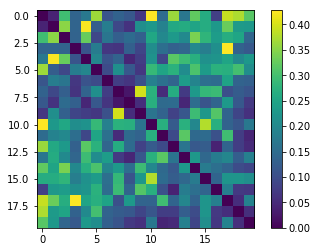

In [14]:
plt.imshow(dists)
plt.colorbar()

Text(0,0.5,'JS Divergence')

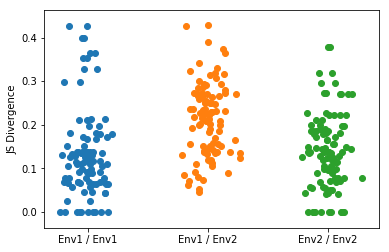

In [15]:
E1E1 = dists[0:ntrials, 0:ntrials].flatten()
E1E2 = dists[ntrials:, 0:ntrials].flatten()
E2E2 = dists[ntrials:, ntrials:].flatten()


plt.scatter(0+0.1*np.random.randn(len(E1E2)), E1E1)
plt.scatter(1+0.1*np.random.randn(len(E1E2)), E1E2)
plt.scatter(2+0.1*np.random.randn(len(E1E2)), E2E2)
plt.xticks([0, 1, 2], ['Env1 / Env1', 'Env1 / Env2', 'Env2 / Env2'])
plt.ylabel('JS Divergence')

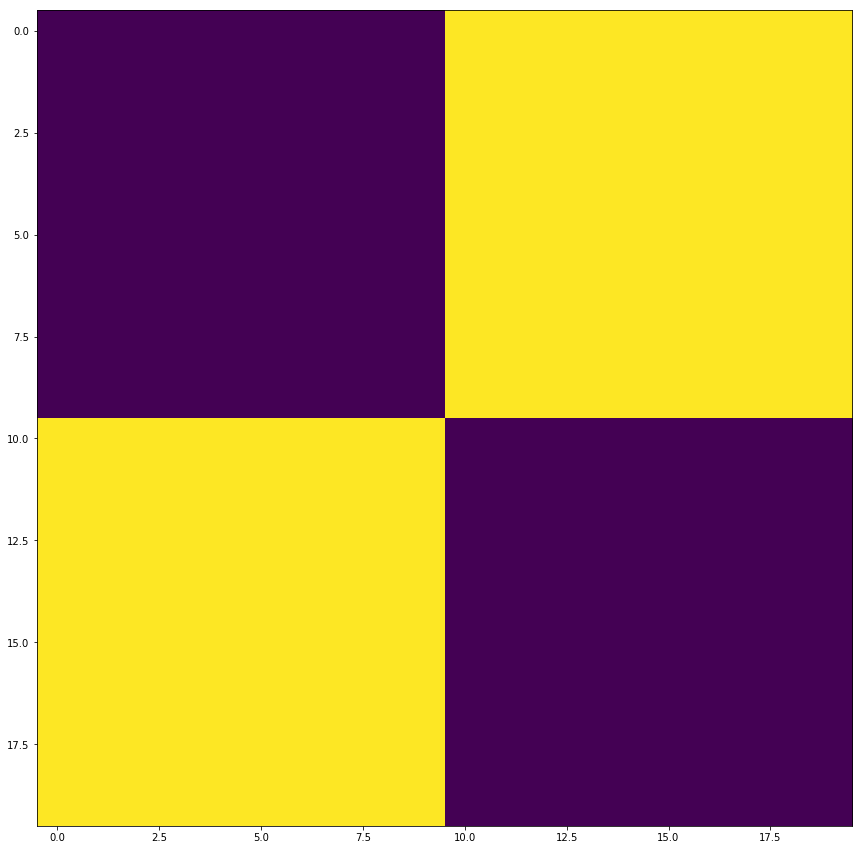

In [66]:
predictedJSmat = np.zeros((2*ntrials, 2*ntrials))
predictedJSmat[ntrials:, 0:ntrials] =1
predictedJSmat[0:ntrials, ntrials:] = 1

plt.figure(figsize=(15, 15))
plt.imshow(predictedJSmat)

In [ ]:
E2s

In [ ]:
pyslsa.JS(E1s[1], E2s[0], dim ,beta)

In [21]:
import pickle
from neuraltda.pyslsa_environments import TPEnv
with open('/home/brad/environment_out22.pkl', 'rb') as f:
    (dists, spikes, fields, envs, corrmat) = pickle.load(f)

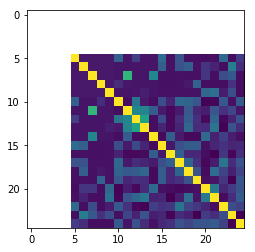

In [22]:
# environment correlation matrix
plt.imshow(corrmat)

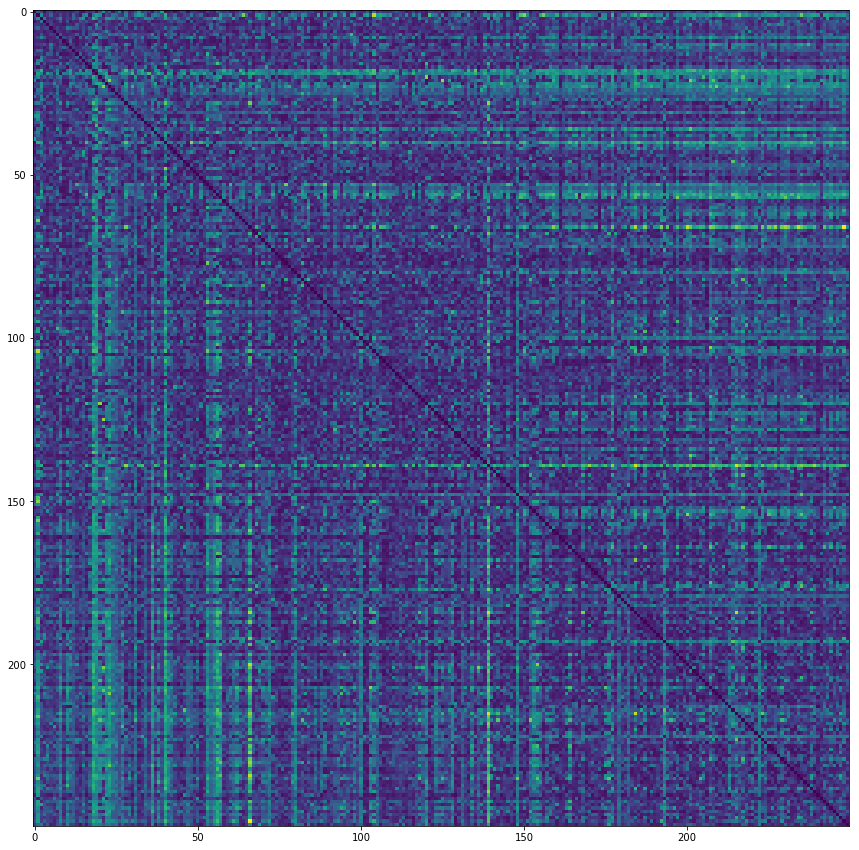

In [24]:
plt.figure(figsize=(15, 15))

dsym = dists + np.transpose(dists)
plt.imshow(dsym)

In [44]:
nenvs = len(envs)
ntrials = 10
nreps = 5
nholes = 5

e1e2means = np.zeros((nenvs, nenvs))
for env1 in range(nenvs):
    for env2 in range(nenvs):
        
        env1env2mean = np.mean(dsym[env1*ntrials:(env1*ntrials + ntrials), env2*ntrials:(env2*ntrials + ntrials)])
        e1e2means[env1, env2] = env1env2mean
        
hole_mat = np.zeros((nholes, nholes))
for b1 in range(nholes):
    for b2 in range(nholes):
        
        m = np.mean(e1e2means[b1*nreps:(b1*nreps+nreps), b2*nreps:(b2*nreps+nreps)])
        hole_mat[b1, b2] = m

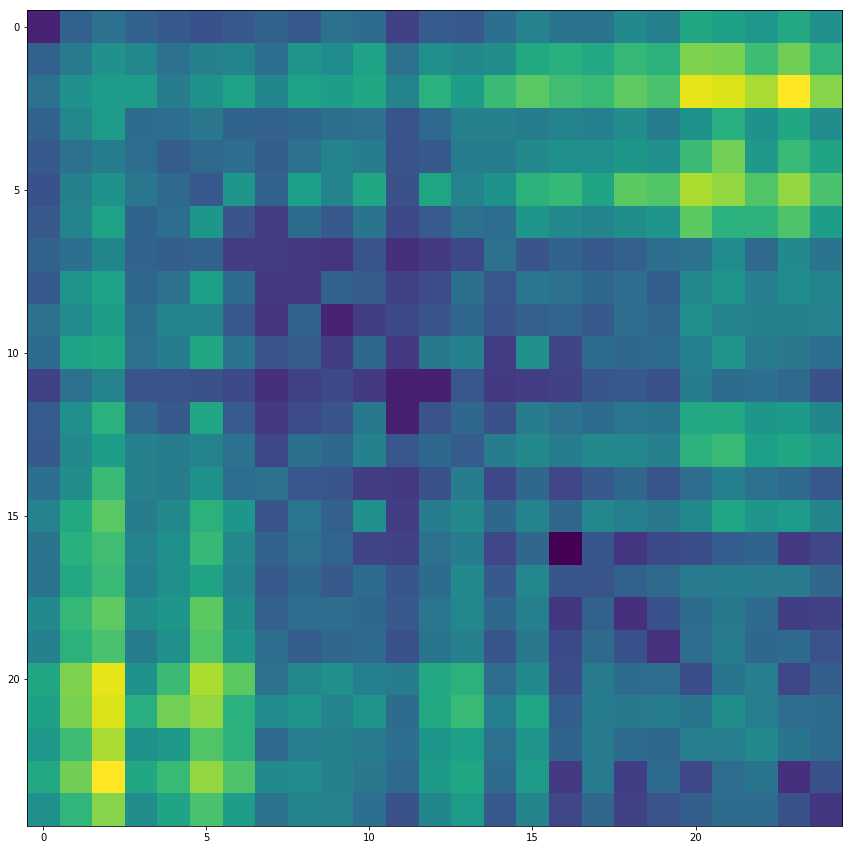

In [28]:
plt.figure(figsize=(15, 15))
plt.imshow(e1e2means)

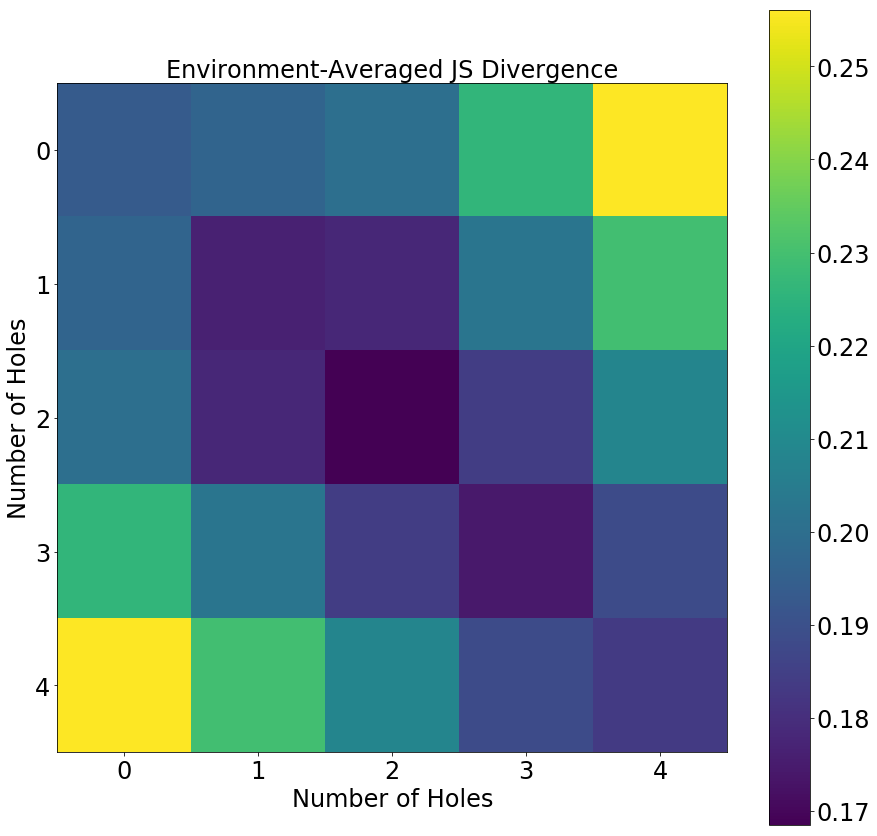

In [60]:
plt.figure(figsize=(15, 15))
plt.imshow(hole_mat)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
#cbar.set_label('JS Divergence')

plt.xlabel('Number of Holes')
plt.ylabel('Number of Holes')
plt.title('Environment-Averaged JS Divergence', size=24)
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)
plt.savefig('/home/brad/placecellsim/envavgedJS.pdf')

In [41]:

good_cor = corrmat[0:, 0:]
good_cor[np.isnan(good_cor)] = 1
good_e1e2m = e1e2means[0:, 0:]
cor_els = good_cor[np.triu_indices(25, 0)]
e1e2m_els = good_e1e2m[np.triu_indices(25, 0)]


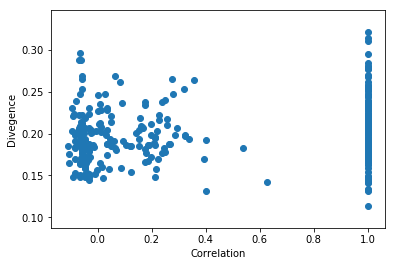

In [42]:
plt.scatter(cor_els, e1e2m_els)
plt.xlabel('Correlation')
plt.ylabel('Divegence')

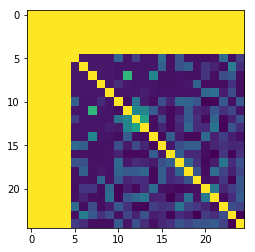

In [43]:
plt.imshow(good_cor)

In [ ]:
is_nan